This notebook shows some examples of fitting different models to classification/regression datasets. We start by loading some classifiers / regressors from `imodels`.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn import metrics

# installable with: `pip install imodels`
import imodels
from imodels import SLIMClassifier, OneRClassifier, BoostedRulesClassifier, FIGSClassifier, HSTreeClassifierCV
from imodels import SLIMRegressor, BayesianRuleListClassifier, RuleFitRegressor, GreedyRuleListClassifier
from imodels.discretization import ExtraBasicDiscretizer
import demo_helper
np.random.seed(13)

Let's start by loading some data in...

In [2]:
# ames housing dataset: https://www.openml.org/search?type=data&status=active&id=43926
X_train_reg, X_test_reg, y_train_reg, y_test_reg, feat_names_reg = demo_helper.get_ames_data()


# diabetes dataset: https://www.openml.org/search?type=data&sort=runs&id=37&status=active
X_train, X_test, y_train, y_test, feat_names = demo_helper.get_diabetes_data()
    # feat_names meanings:
    # ["#Pregnant", "Glucose concentration test", "Blood pressure(mmHg)",
    # "Triceps skin fold thickness(mm)",
    # "2-Hour serum insulin (mu U/ml)", "Body mass index", "Diabetes pedigree function", "Age (years)"]

# load some data
print('Regression data training', X_train_reg.shape, 'Classification data training', X_train.shape)

Regression data training (365, 33) Classification data training (192, 8)


We will now show how to fit different models. All models support the `fit` and `predict` method (classifiers also support `predict_proba`).

The simplest way to visualize a fitted model `m` is usually just to call `str(m)` or `print(m)`. Some models have custom methods that allow you to visualize them further...To pass feature names into a model for visualization, you can usually (i) pass in the `feature_names` argument to the `fit` function or (ii) pass in a pandas dataframe with the feature names as column names.

Let's overview 4 types of models: (1) Rule sets, (2) Rule trees, (3) Rule lists, and (4) Algebraic models.

<div>
<img src="https://csinva.io/imodels/img/model_table.png" width="500"/>
</div>

# 1. Rule sets
Rule sets are models that create a set of (potentially overlapping) rules.

### Rulefit

In [12]:
# fit a rulefit model
rulefit = RuleFitRegressor(max_rules=10)
rulefit.fit(X_train_reg, y_train_reg, feature_names=feat_names_reg)

# get test performance
preds = rulefit.predict(X_test_reg)
print(f'Test R2: {metrics.r2_score(y_test_reg, preds):0.2f}')

rulefit

Test R2: 0.67


RuleFitRegressor(max_rules=10)

In [13]:
# inspect and print the rules
print('Rulefit has an alternative visualization:')
rules = rulefit._get_rules()
rules = rules[rules.coef != 0].sort_values("support", ascending=False)
    # 'rule' is how the feature is constructed
    # 'coef' is its weight in the final linear model
    # 'support' is the fraction of points it applies to
display(rules[['rule', 'coef', 'support']].style.background_gradient(cmap='viridis'))

Rulefit has an alternative visualization:


,rule,coef,support
2,OverallQual,15027.639442,1.000000
9,TotalBsmtSF,6.248934,1.000000
13,GrLivArea,33.283951,1.000000
23,GarageArea,25.491501,1.000000
36,OverallQual <= 7.5 and TotalBsmtSF <= 1201.0,-13127.958940,0.641096
34,GrLivArea <= 1790.0 and YearBuilt <= 1994.5,-2918.816315,0.550685
35,GrLivArea <= 1789.5 and TotalBsmtSF <= 1199.5,-775.146485,0.547945
33,1stFlrSF <= 1417.0 and YearBuilt <= 1983.5,-7386.986538,0.479452
37,GrLivArea > 1744.0 and OverallQual > 6.5,13073.210572,0.169863


## Boosted stumps

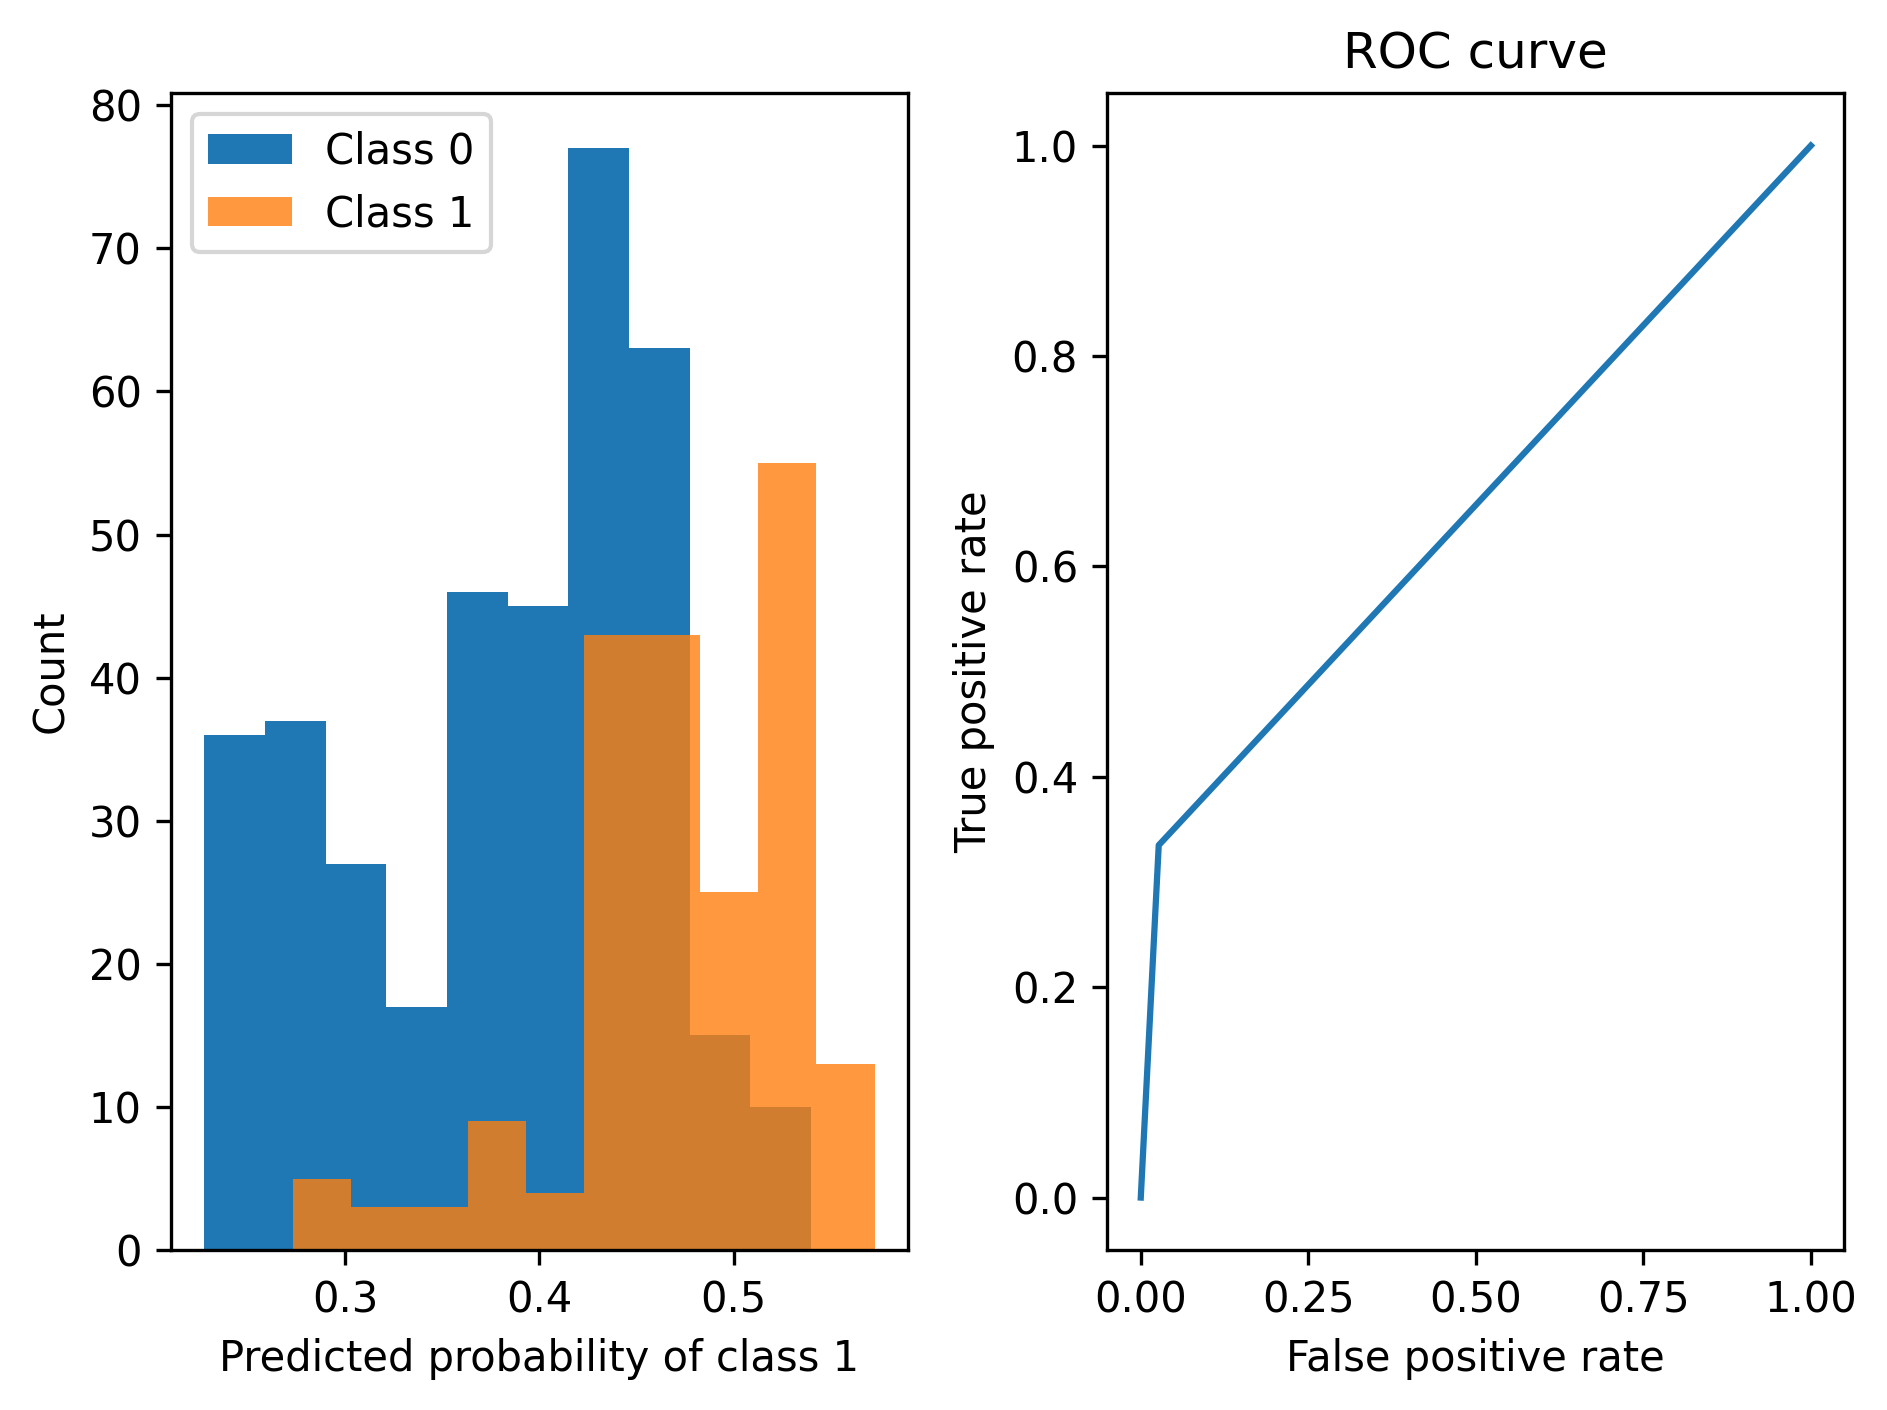

BoostedRulesClassifier()

In [6]:
# fit boosted stumps
brc = BoostedRulesClassifier(n_estimators=10)
brc.fit(X_train, y_train, feature_names=feat_names)

# look at performance
probs = brc.predict_proba(X_test)
demo_helper.viz_classification_preds(probs, y_test)

brc

# 2. Rule trees

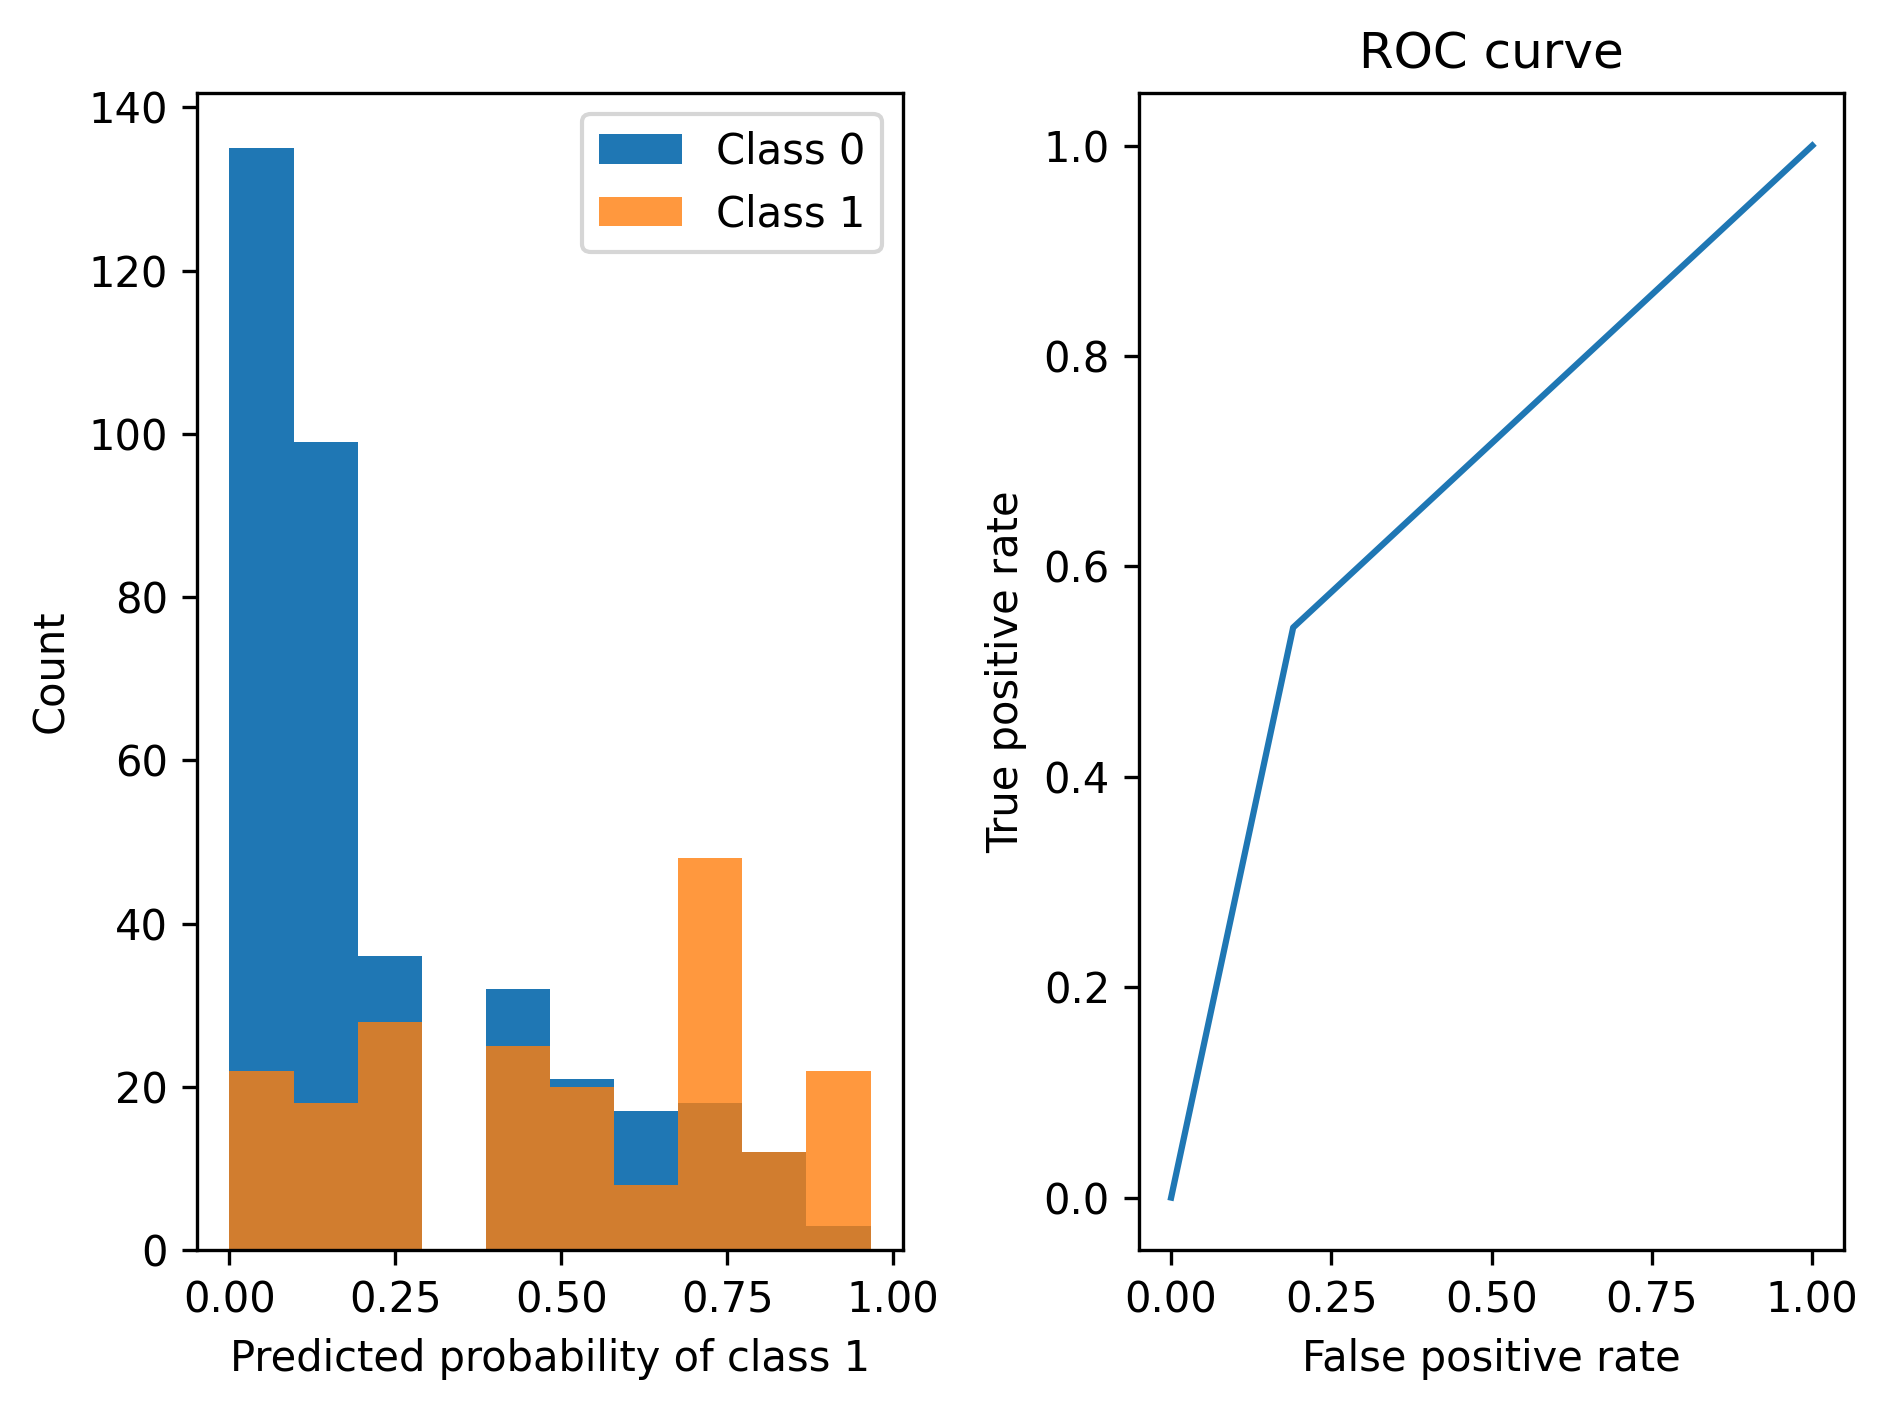

FIGSClassifier(max_rules=7)

In [14]:
# specify a decision tree with a maximum depth
figs = FIGSClassifier(max_rules=7)
figs.fit(X_train, y_train, feature_names=feat_names)

# calculate mse on the training data
probs = figs.predict_proba(X_test)
# print(f'test mse: {np.mean(np.square(preds-y)):0.2f}')
demo_helper.viz_classification_preds(probs, y_test)

figs

Alternative visualization:


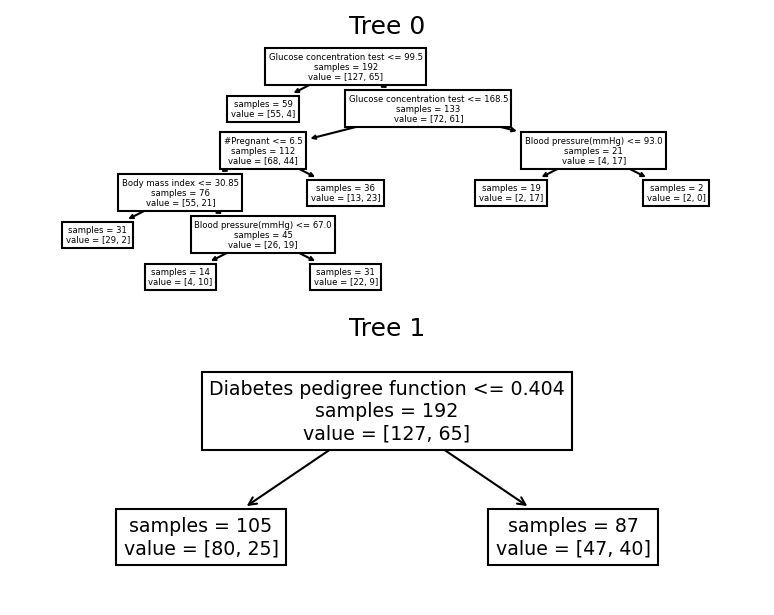

In [15]:
print('Alternative visualization:')
figs.plot()

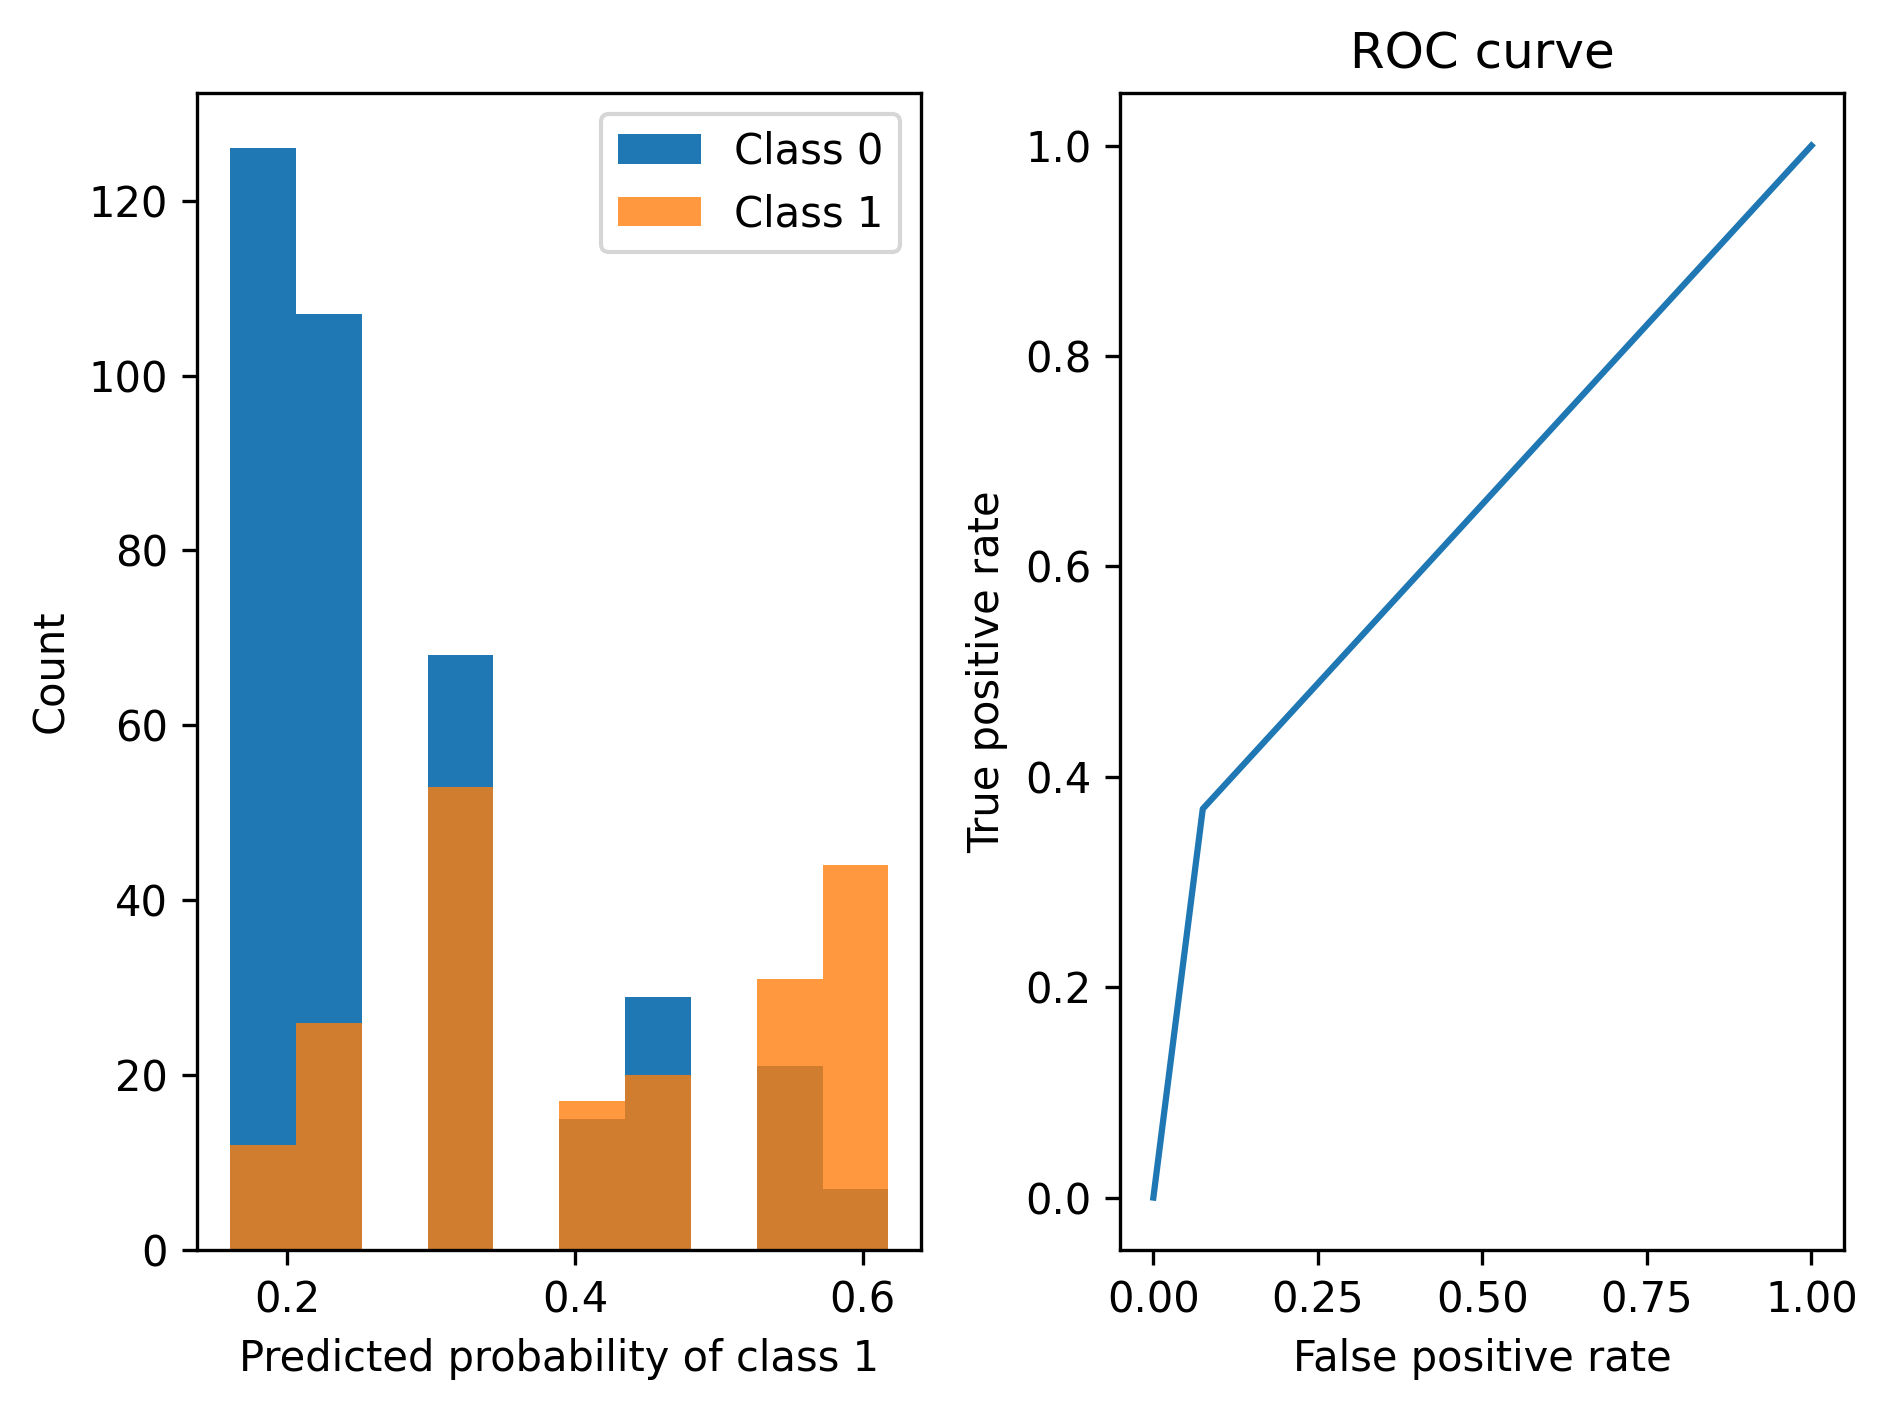

In [16]:
# specify a decision tree with a maximum depth
dt = HSTreeClassifierCV(max_leaf_nodes=7)
dt.fit(X_train, y_train, feature_names=feat_names)

# calculate mse on the training data
probs = dt.predict_proba(X_test)
# print(f'test mse: {np.mean(np.square(preds-y)):0.2f}')
demo_helper.viz_classification_preds(probs, y_test)

dt

Alternative visualization:


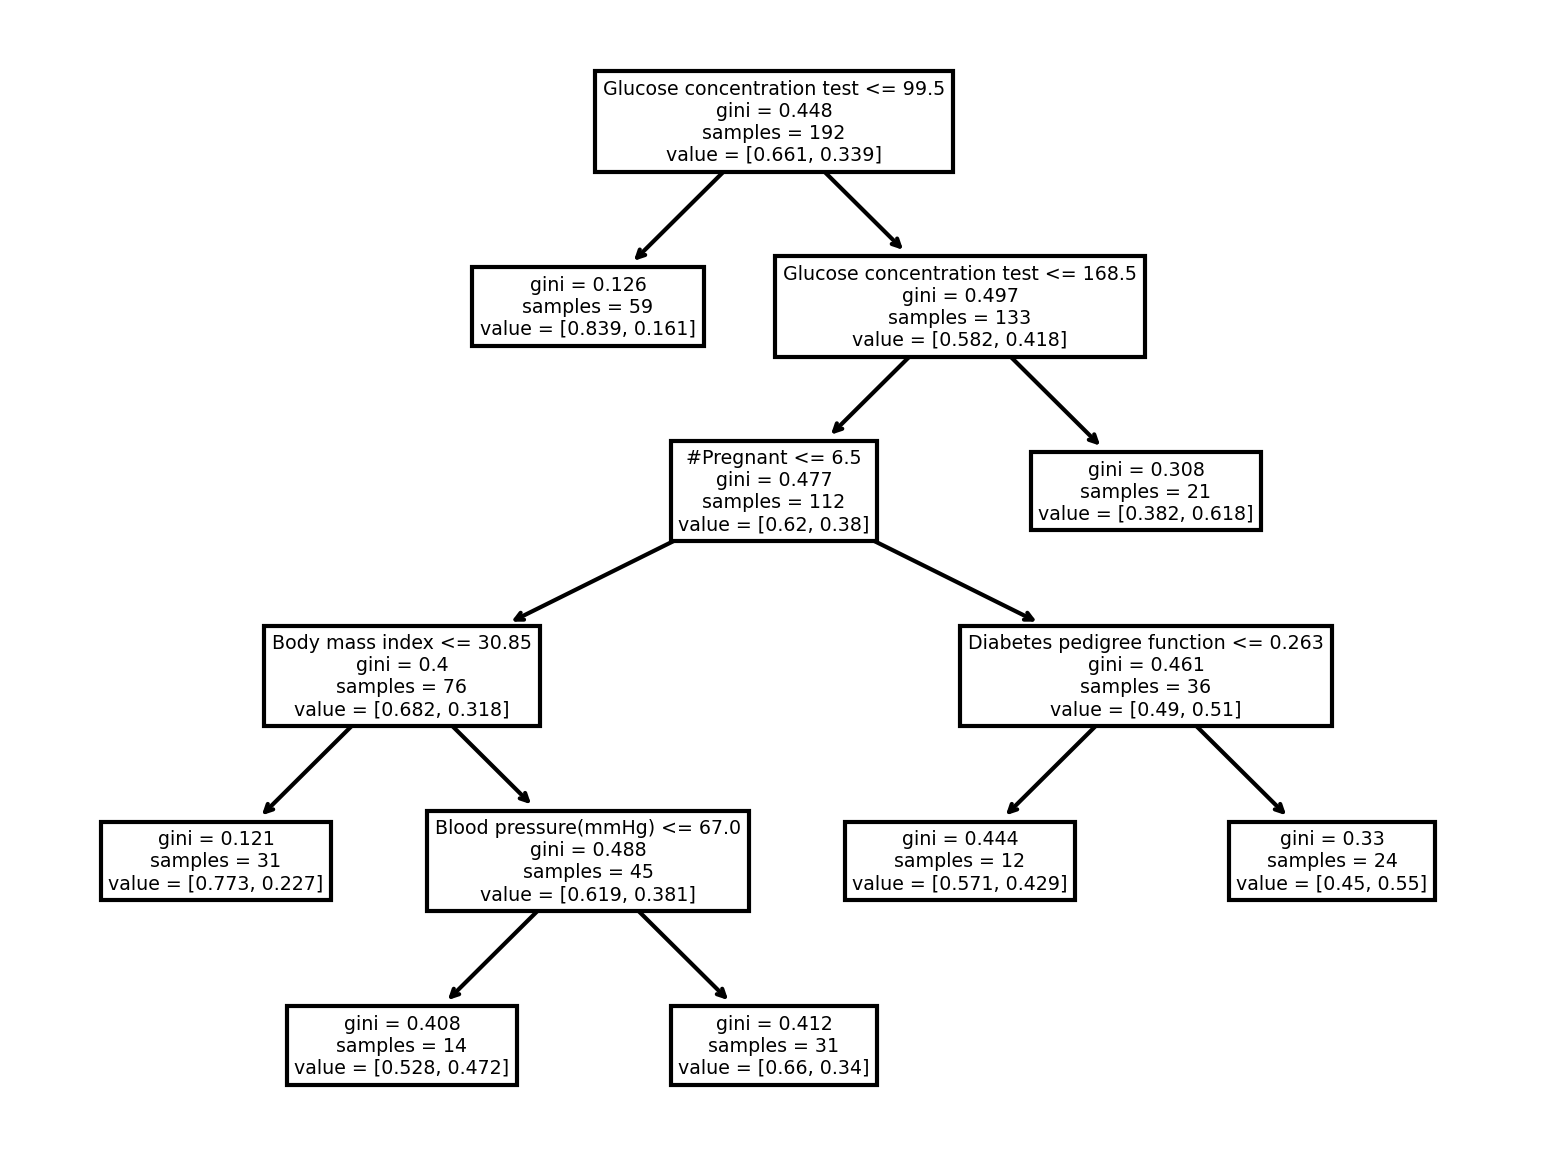

In [17]:
print('Alternative visualization:')
plot_tree(dt.estimator_, feature_names=feat_names)
# plt.savefig('tree.pdf')
plt.show()

# 3. Rule lists

### Greedy rule lists
**like a decision tree that only ever splits going left**

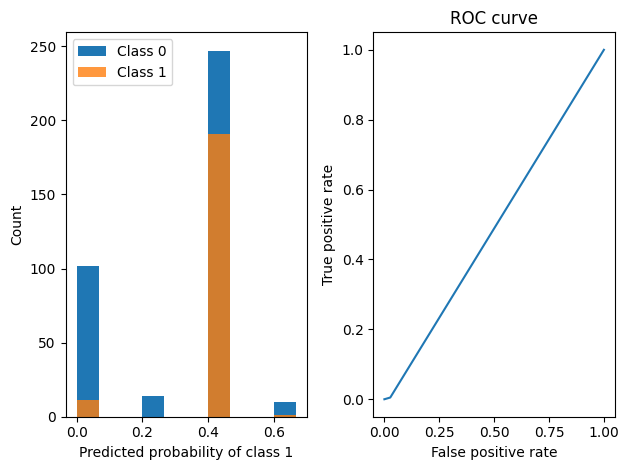

GreedyRuleListClassifier()

In [3]:
# fit a greedy rule list
m = GreedyRuleListClassifier()
m.fit(X_train, y=y_train, feature_names=feat_names)  # stores into m.rules_
probs = m.predict_proba(X_test)

# look at prediction breakdown
demo_helper.viz_classification_preds(probs, y_test)

m

### oneR
**fits a rule list restricted to use only one feature**

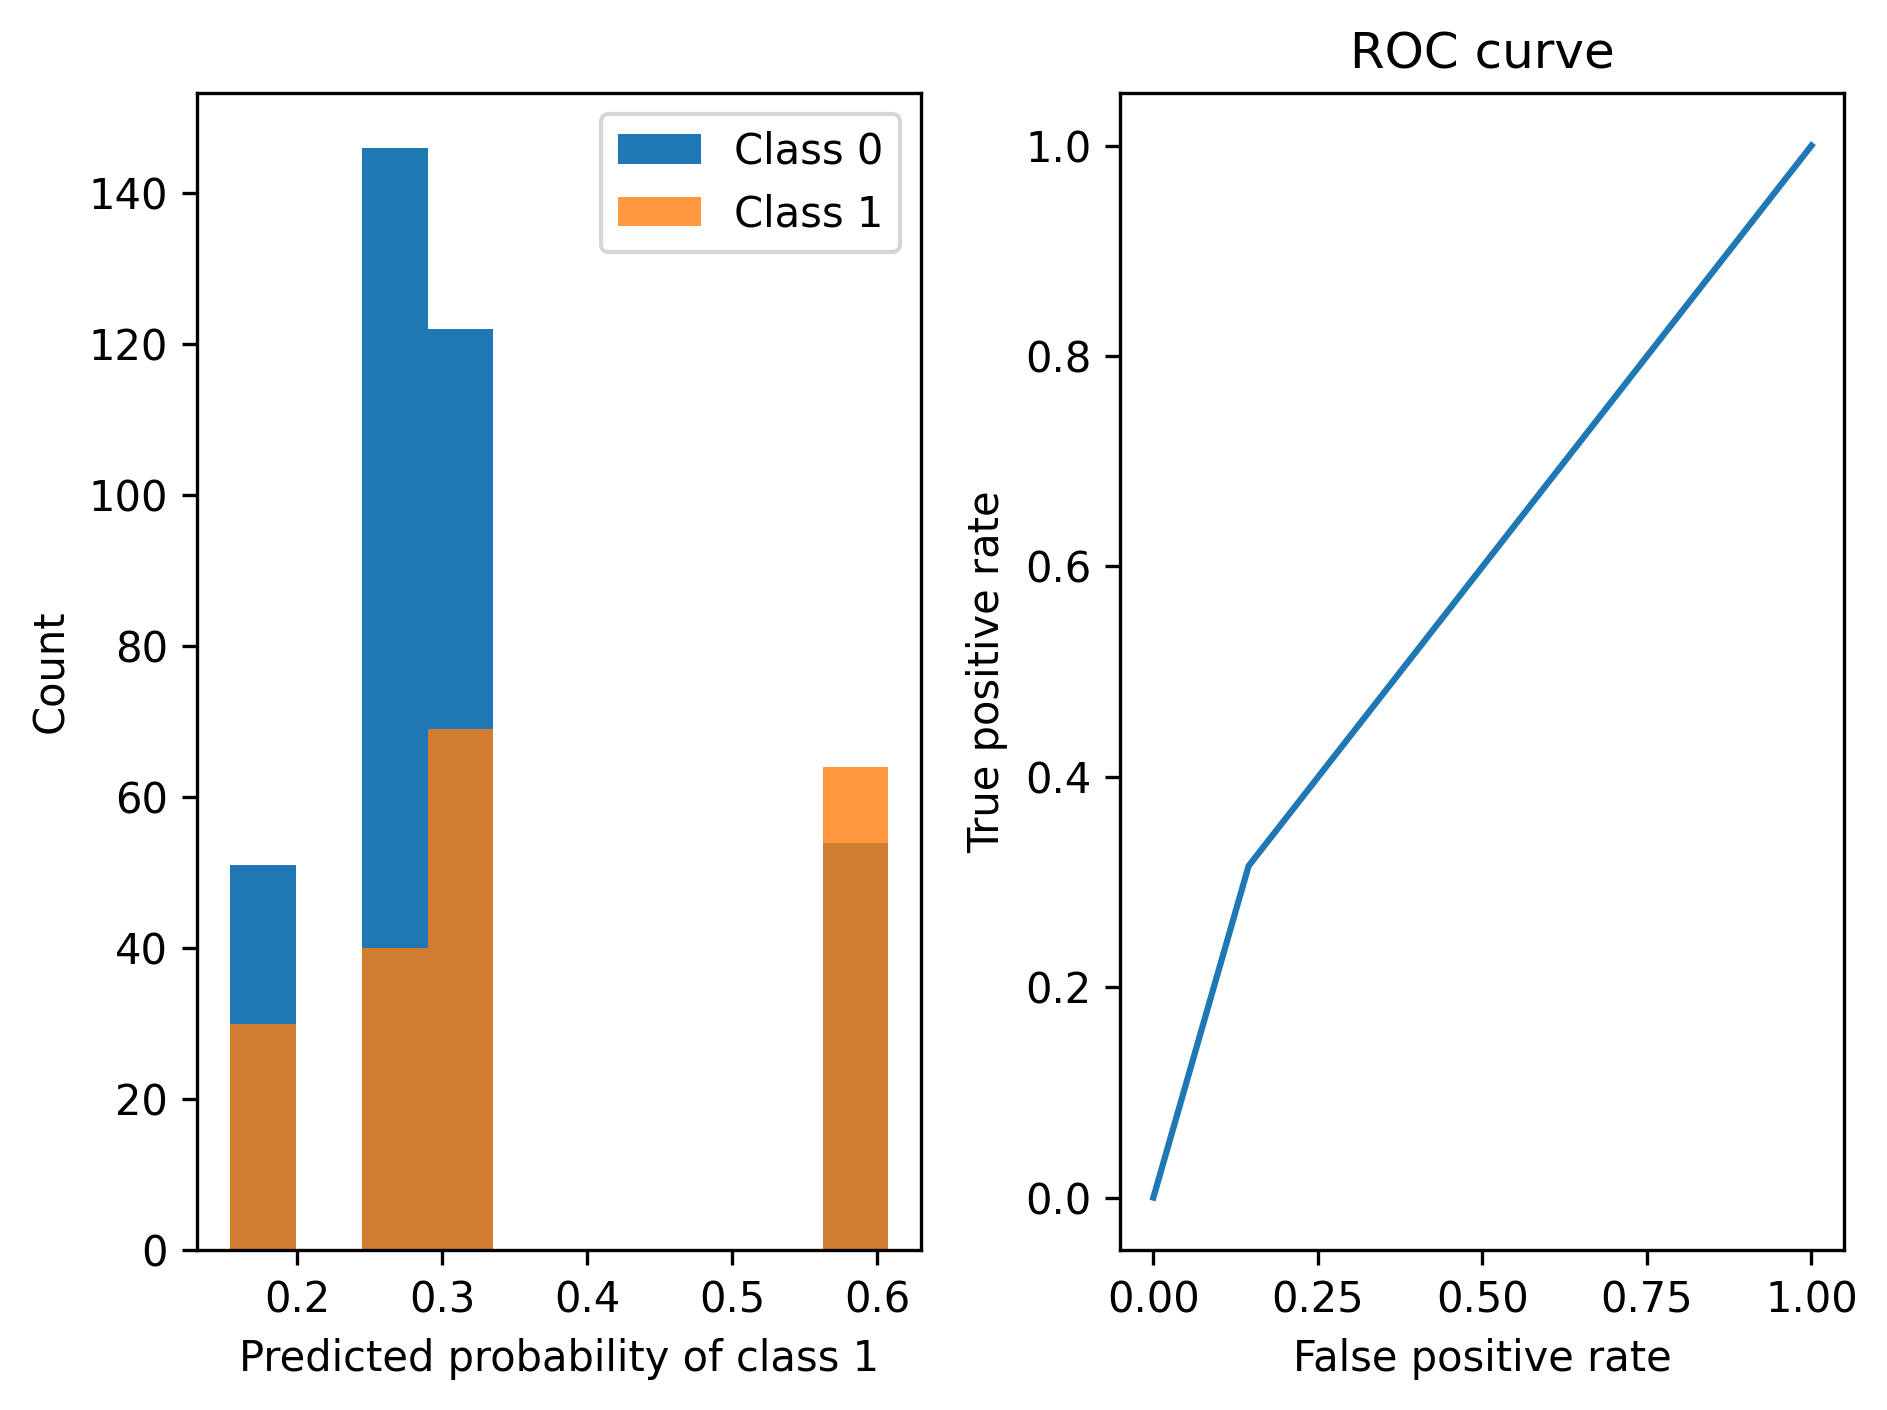

OneRClassifier()

In [24]:
# fit a oneR model
m = OneRClassifier()
m.fit(X_train, y=y_train, feature_names=feat_names)  # stores into m.rules_
probs = m.predict_proba(X_test)

# look at prediction breakdown
demo_helper.viz_classification_preds(probs, y_test)

m

### Scalable bayesian rule lists

In [25]:
disc = ExtraBasicDiscretizer(feat_names[:3], n_bins=3, strategy='uniform')
X_train_brl_df = disc.fit_transform(pd.DataFrame(X_train[:, :3], columns=feat_names[:3]))
X_test_brl_df = disc.transform(pd.DataFrame(X_test[:, :3], columns=feat_names[:3]))

training...


/home/chansingh/.embgam/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


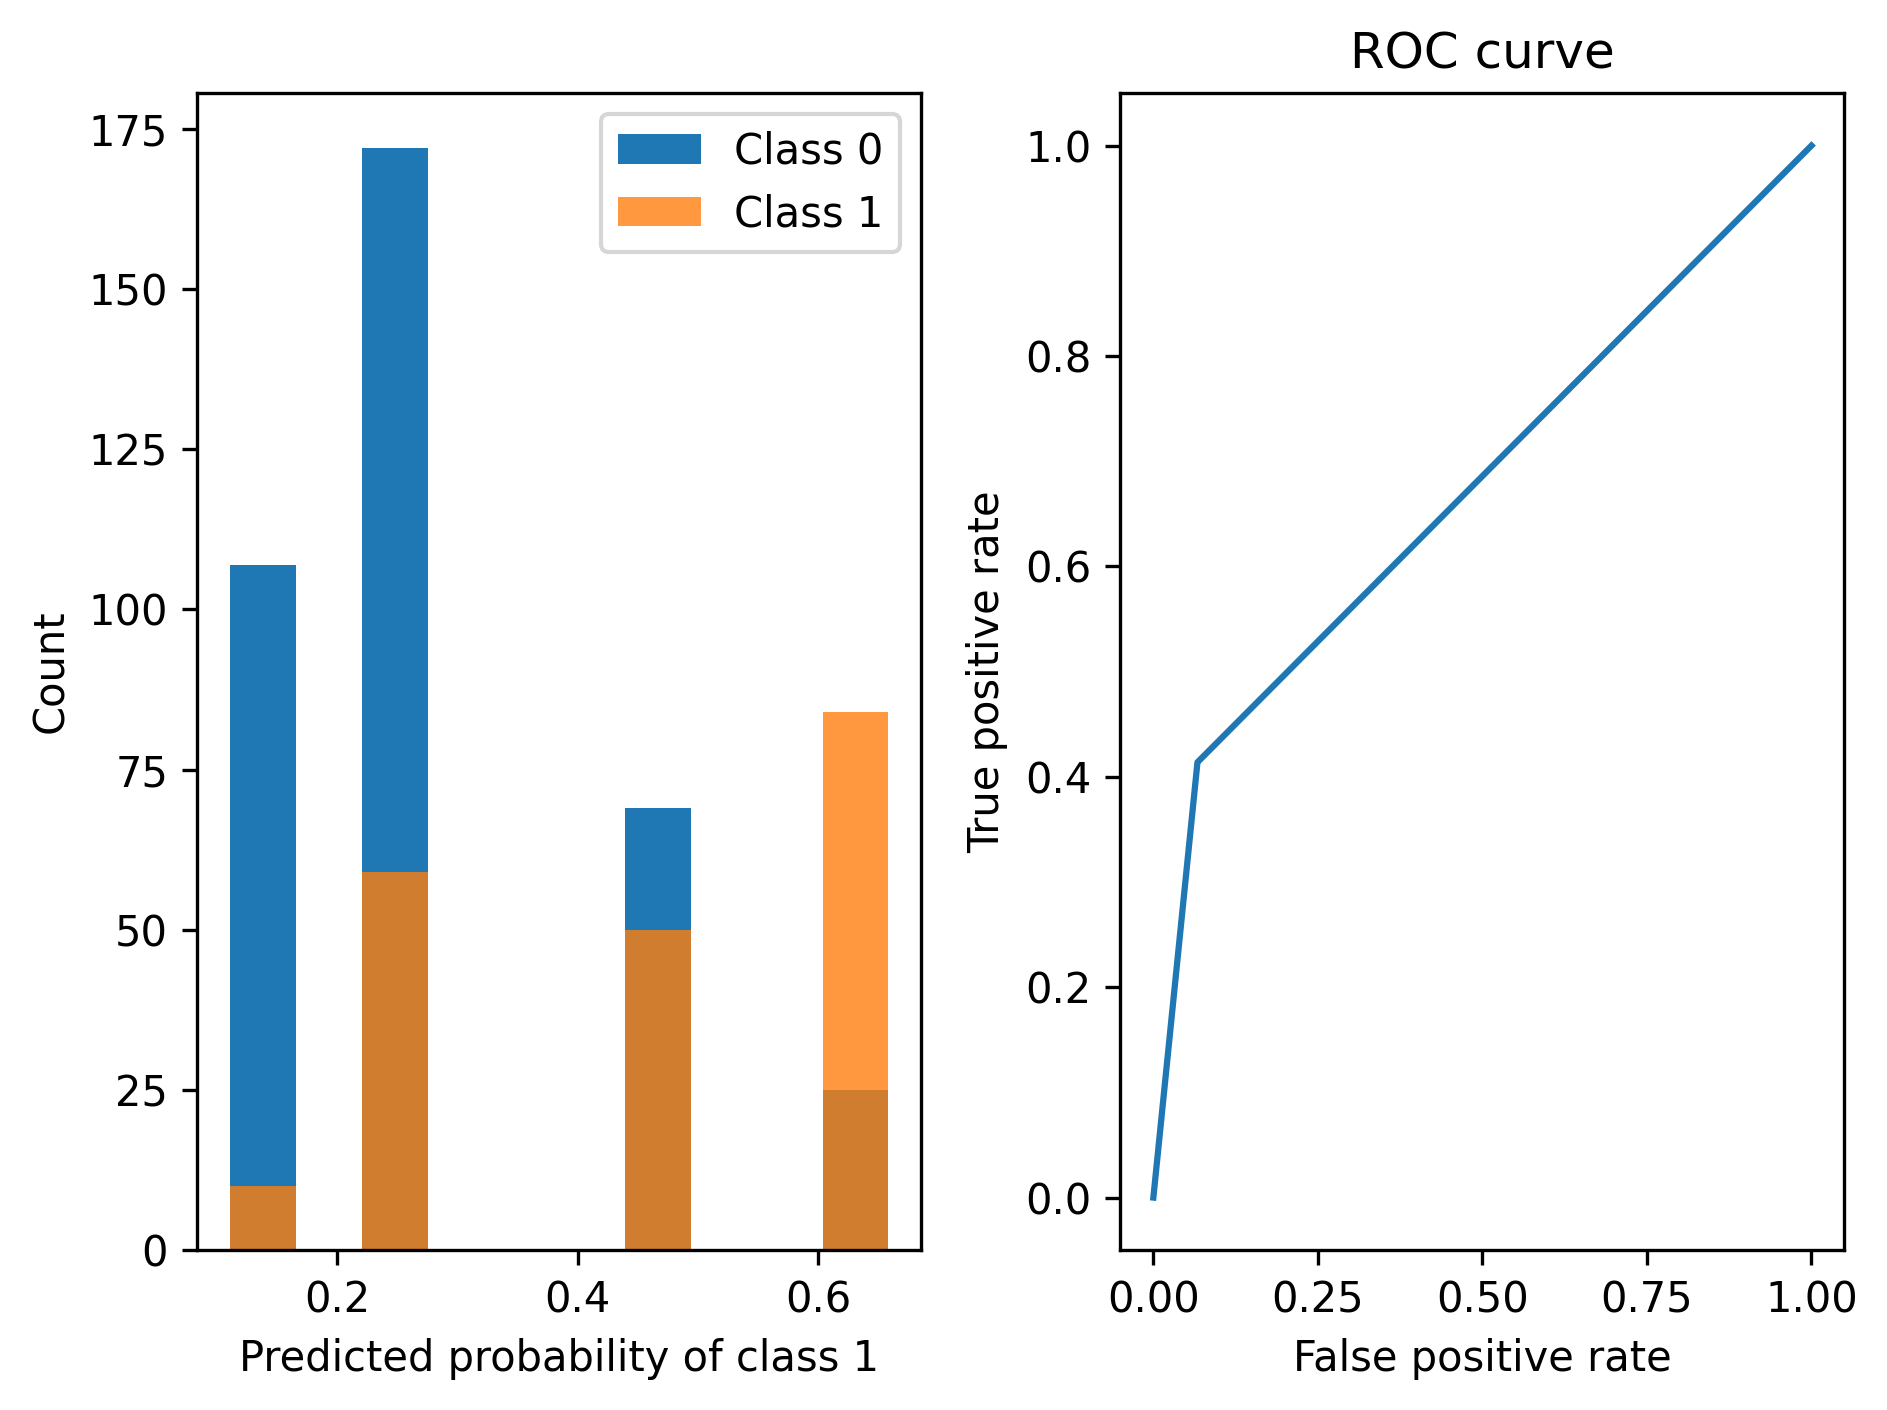

Trained RuleListClassifier 
============================
IF Glucose concentration test_147.33333333333331_to_199.0 > 0.5 THEN probability of class 1: 65.9% (50.9%-79.4%)
ELSE IF Glucose concentration test_44.0_to_95.66666666666666 > 0.5 THEN probability of class 1: 11.1% (3.8%-21.7%)
ELSE IF #Pregnant_0.0_to_4.666666666666667 > 0.5 THEN probability of class 1: 22.9% (13.9%-33.3%)
ELSE probability of class 1: 47.7% (33.3%-62.3%)
===========================

In [28]:
# train classifier (allow more iterations for better accuracy; use BigDataRuleListClassifier for large datasets)
print('training...')
m = BayesianRuleListClassifier()
m.fit(X_train_brl_df.values, y_train, feature_names=X_train_brl_df.columns)

probs = m.predict_proba(X_test_brl_df.values)
demo_helper.viz_classification_preds(probs, y_test)

m

# Algebraic models

### Integer linear models

In [29]:
np.random.seed(123)

# generate X and y
n, p = 500, 10
X_sim = np.random.randn(n, p)
y_sim = 1 * X_sim[:, 0] + 2 * X_sim[:, 1] - 1 * X_sim[:, 2] + np.random.randn(n)

# fit linear models with different regularization parameters
print('groundtruth weights should be 1, 2, -1...')
model = SLIMRegressor()
for lambda_reg in [1e-3, 1e-2, 5e-2, 1e-1, 1, 2, 5, 10]:
    model.fit(X_sim, y_sim, lambda_reg)
    mse = np.mean(np.square(y_sim - model.predict(X_sim)))
    print(f'lambda: {lambda_reg}\tmse: {mse: 0.2f}\tweights: {model.model_.coef_}')

groundtruth weights should be 1, 2, -1...
lambda: 0.001	mse:  0.93	weights: [ 1  2 -1  0  0  0  0  0  0  0]
lambda: 0.01	mse:  0.93	weights: [ 1  2 -1  0  0  0  0  0  0  0]
lambda: 0.05	mse:  0.93	weights: [ 1  2 -1  0  0  0  0  0  0  0]
lambda: 0.1	mse:  0.93	weights: [ 1  2 -1  0  0  0  0  0  0  0]
lambda: 1	mse:  0.93	weights: [ 1  2 -1  0  0  0  0  0  0  0]
lambda: 2	mse:  0.93	weights: [ 1  2 -1  0  0  0  0  0  0  0]
lambda: 5	mse:  0.93	weights: [ 1  2 -1  0  0  0  0  0  0  0]
lambda: 10	mse:  0.93	weights: [ 1  2 -1  0  0  0  0  0  0  0]


/home/chansingh/imodels/imodels/algebraic/slim.py:73: UserWarning: Should install cvxpy with pip install cvxpy. Rounding non-integer coefficients instead.
  warnings.warn("Should install cvxpy with pip install cvxpy. Rounding non-integer "
/home/chansingh/imodels/imodels/algebraic/slim.py:73: UserWarning: Should install cvxpy with pip install cvxpy. Rounding non-integer coefficients instead.
  warnings.warn("Should install cvxpy with pip install cvxpy. Rounding non-integer "
/home/chansingh/imodels/imodels/algebraic/slim.py:73: UserWarning: Should install cvxpy with pip install cvxpy. Rounding non-integer coefficients instead.
  warnings.warn("Should install cvxpy with pip install cvxpy. Rounding non-integer "
/home/chansingh/imodels/imodels/algebraic/slim.py:73: UserWarning: Should install cvxpy with pip install cvxpy. Rounding non-integer coefficients instead.
  warnings.warn("Should install cvxpy with pip install cvxpy. Rounding non-integer "
/home/chansingh/imodels/imodels/algebrai

In [30]:
model

SLIMRegressor()

In [ ]:
y_sim = 1 / (1 + np.exp(-y_sim))
y_sim = np.round(y_sim)

# fit linear models with different regularization parameters
print('groundtruth weights should be 1, 2, -1...')
model = SLIMClassifier()
for lambda_reg in [1e-3, 1e-2, 5e-2, 1e-1, 1, 2, 5, 10]:
    model.fit(X_sim, y_sim, lambda_reg)
    mll = np.mean(metrics.log_loss(y_sim, model.predict(X_sim)))
    print(f'lambda: {lambda_reg}\tmlogloss: {mll: 0.2f}\tweights: {model.model_.coef_}')